# Mistral-AWS ecosystem LLM router (ReAct agent)

In this Jupyter Notebook, we walk through an example of using a [LangChain ReAct agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/react/) with [Mistral Large 2](https://mistral.ai/news/mistral-large-2407/) as the orchestrator. As part of this notebook, we will be leveraging previous SageMaker real-time inference endpoint notebooks in our repository for a few Mistral models. We will be deploying [Mathstral](https://huggingface.co/mistralai/Mathstral-7B-v0.1), and [Pixtral](mistralai/Pixtral-12B-2409) models specifically to tgi/lmi based SageMaker endpoints. We will demonstrate how Mistral Large 2 on Amazon Bedrock, with the ReAct agent is able to decompose a complex prompt, reason through the steps needed to accomplish the task and perform function calls to different llms in the Mistral ecosystem to perform these specific subtasks such as mathematical reasoning, vision-based tasks, code generation, etc. We also provide the ReAct agent a function to be able to compile and execute code using [JDoodle](https://www.jdoodle.com/integrate-online-ide-compiler-api-plugins) to provide more end-to-end results. In the latter half of this notebook, we have also included some use cases such as Financial Report analysis where these models work together as tools provided to the ReAct agent to solve problems collectively by having Mistral Large 2 reason through the steps.

<div class="alert alert-block alert-warning"> 

<b>NOTE:</b> Here we only use a single ReAct agent for demonstration purpose
</div>

---
## Orchestrator:

### Mistral Large 2
- **Description:** [Mistral Large 2](https://mistral.ai/news/mistral-large-2407/) is the most advanced language model developed by French AI startup Mistral AI. It also has support for function calling and JSON format.
- **Max Tokens:** 8,196
- **Context Window:** 128k
- **Languages:** Natively fluent in French, German, Spanish, Italian, Portuguese, Arabic, Hindi, Russian, Chinese, Japanese, and Korean
- **Supported Use Cases:** precise instruction following, text summarization, translation, complex multilingual reasoning tasks, math and coding tasks including code generation

### Performance and Cost Trade-offs

The table below compares the model performance on the Massive Multitask Language Understanding (MMLU) benchmark and their on-demand pricing on Amazon Bedrock.

| Model           | MMLU Score | Price per 1,000 Input Tokens | Price per 1,000 Output Tokens |
|-----------------|------------|------------------------------|-------------------------------|
| Mistral Large 2 | 84.0%      | \$0.004                   | \$0.012                     |

For more information, refer to the following links:

1. [Mistral Model Selection Guide](https://docs.mistral.ai/guides/model-selection/)
2. [Amazon Bedrock Pricing Page](https://aws.amazon.com/bedrock/pricing/)


## Models as function calls:

- Mistral Large 2 for code gen
- Mathstral
- Pixtral
- Mixtral 8x7b

---
## Supported parameters

The Mistral AI models have the following inference parameters.


```
{
    "prompt": string,
    "max_tokens" : int,
    "stop" : [string],    
    "temperature": float,
    "top_p": float,
    "top_k": int
}
```

The Mistral AI models have the following inference parameters:

- **Temperature** - Tunes the degree of randomness in generation. Lower temperatures mean less random generations.
- **Top P** - If set to float less than 1, only the smallest set of most probable tokens with probabilities that add up to top_p or higher are kept for generation.
- **Top K** - Can be used to reduce repetitiveness of generated tokens. The higher the value, the stronger a penalty is applied to previously present tokens, proportional to how many times they have already appeared in the prompt or prior generation.
- **Maximum Length** - Maximum number of tokens to generate. Responses are not guaranteed to fill up to the maximum desired length.
- **Stop sequences** - Up to four sequences where the API will stop generating further tokens. The returned text will not contain the stop sequence.

---

### Local Setup (Optional)

For a local server, follow these steps to execute this jupyter notebook:

1. **Configure AWS CLI**: Configure [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html) with your AWS credentials. Run `aws configure` and enter your AWS Access Key ID, AWS Secret Access Key, AWS Region, and default output format.

2. **Install required libraries**: Install the necessary Python libraries for working with SageMaker, such as [sagemaker](https://github.com/aws/sagemaker-python-sdk/), [boto3](https://github.com/boto/boto3), and others. You can use a Python environment manager like [conda](https://docs.conda.io/en/latest/) or [virtualenv](https://virtualenv.pypa.io/en/latest/) to manage your Python packages in your preferred IDE (e.g. [Visual Studio Code](https://code.visualstudio.com/)).

3. **Create an IAM role for SageMaker**: Create an AWS Identity and Access Management (IAM) role that grants your user [SageMaker permissions](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html). 

By following these steps, you can set up a local Jupyter Notebook environment capable of deploying machine learning models on Amazon SageMaker using the appropriate IAM role for granting the necessary permissions.

## Notebook Setup and Requirements

---
1. Create an Amazon SageMaker Notebook Instance - [Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html)
    - For Notebook Instance type, choose ml.t3.medium.
2. For Select Kernel, choose [conda_python3](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-prepare.html).
3. Install the required packages.

<div class="alert alert-block alert-info"> 

<b>NOTE:

- </b> For <a href="https://aws.amazon.com/sagemaker/studio/" target="_blank">Amazon SageMaker Studio</a>, select Kernel "<span style="color:green;">Python 3 (ipykernel)</span>".

- For <a href="https://docs.aws.amazon.com/sagemaker/latest/dg/studio.html" target="_blank">Amazon SageMaker Studio Classic</a>, select Image "<span style="color:green;">Base Python 3.0</span>" and Kernel "<span style="color:green;">Python 3</span>".

</div>

---

Before we start building the agentic workflow, we'll first install some libraries:

+ AWS Python SDKs [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to be able to submit API calls to [Amazon Bedrock](https://aws.amazon.com/bedrock/).
---

## Prerequisites

Before we get started with the notebook, we first need to complete the steps below:

1. Deploy Mathstral endpoint:
- Follow through with the steps in the [Mathstral-TGI-notebook](https://github.com/aws-samples/mistral-on-aws/blob/main/notebooks/Mathstral-samples/Mathstral-TGI-deployment-nb.ipynb) to deploy the model to a SageMaker endpoint and the grab the endpoint name from the SageMaker dashboard.

2. Deploy Pixtral endpoint:
- Follow through with the steps in the [Pixtral-LMI-notebook](https://github.com/aws-samples/mistral-on-aws/blob/main/notebooks/Pixtral-samples/Pixtral-12b-LMI-SageMaker-realtime-inference.ipynb) to deploy the model to a SageMaker endpoint and the grab the endpoint name from the SageMaker dashboard.

3. Grab Jdoodle Compiler API credentials:
- Navigate to https://www.jdoodle.com/ and create an account.
- Once you create an account, you are able to go to the dashboard, and subscribe to the free api plan for compiling and executing code. 
- You are then able to grab your unique api credentials.

4. Set up your [HuggingFace token](https://huggingface.co/docs/transformers.js/en/guides/private): 
- User Access Tokens are the preferred way to authenticate an application to Hugging Face services.
- To generate an access token, navigate to the Access Tokens tab in your settings and click on the New token button.
- Choose a name for your token and click Generate a token (we recommend keeping the “Role” as read-only). You can then click the Copy button next to your newly-created token to copy it to your clipboard.
- Copy and replace this token below in the `HUGGING_FACE_HUB_TOKEN` parameter under `config` in the deployment section.

---

In [1]:
%%writefile requirements.txt
boto3==1.35.51
langchain==0.3.5
langchain-aws==0.2.4

Writing requirements.txt


Install required packages:

In [2]:
!pip install -qU -r requirements.txt --quiet

Import required packages:

In [3]:
import boto3
from datetime import datetime
import json
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent
from langchain_aws import ChatBedrockConverse

Let's define a few variables and create a bedrock client.

In [4]:
model_id = 'mistral.mistral-large-2407-v1:0'
print(f'Using modelId: {model_id}')

region = 'us-west-2'
print('Using region: ', region)

bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=region
)
sm_client = boto3.client("sagemaker-runtime")

Using modelId: mistral.mistral-large-2407-v1:0
Using region:  us-west-2


---

In the next step, let's create a dict with the model_ids/endpoint_names mapped to all our respective models. For this step, grab the model id for mixtral 8x7b from Bedrock, and the endpoint names for all the models we have spun up in the previous step from the SageMaker Dashboard.


In [6]:
MODEL_MAP = {
    'mistral_large_2':'mistral.mistral-large-2407-v1:0',
    'mixtral': 'mistral.mixtral-8x7b-instruct-v0:1',
    'mathstral':'<REPLACE WITH YOUR ENDPOINT NAME FOR MATHSTRAL>',
    'pixtral':'<REPLACE WITH YOUR ENDPOINT NAME FOR PIXTRAL>'
}

## Create Functions to Invoke Models and Code Compiler
---

In [7]:
# Function to invoke the selected LLM via Bedrock Converse API
def invoke_converse(prompt, model):
    model_id = MODEL_MAP[model]
    messages = [{"role": "user", "content": [{"text": prompt}]}]
    response = bedrock.converse(
        messages=messages,
        modelId=model_id
     #   inferenceConfig=inference_config
    )
    generated_text = response['output']['message']['content'][0]['text']
    #print("Invoke Converse")
    #print(generated_text)
    return generated_text, response

In [8]:
# Invoke the SageMaker endpoint
def invoke_sm_endpoint(payload,model):
    endpoint_name = MODEL_MAP[model]
    payload_json = json.dumps(payload)
    response = sm_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="application/json",
                Accept="application/json",
                Body=payload_json
            )
            # Read and parse the response
    output_data = json.loads(response['Body'].read().decode())
    #print("Invoke SageMaker")
    #print(output_data)
    return output_data[0]['generated_text']
    

In [9]:
# Invoke the SageMaker endpoint for Pixtral
def invoke_sm_endpoint_pixtral(payload,model):
    endpoint_name = MODEL_MAP[model]
    payload_json = json.dumps(payload)
    response = sm_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="application/json",
                Accept="application/json",
                Body=payload_json
            )
            # Read and parse the response
    output_data = json.loads(response['Body'].read().decode())
    #print("Invoke SageMaker")
    #print(output_data)
    return output_data['choices'][0]['message']['content']

In [10]:
#JDoodle POST request for code execution
import requests

def route_to_jdoodle(client_id, client_secret, script, language, version_index='3'):
    """
    This function routes the provided code to the JDoodle API for compilation and execution.

    Args:
    - client_id (str): Your JDoodle API client ID.
    - client_secret (str): Your JDoodle API client secret.
    - script (str): The code/script to compile and execute.
    - language (str): The programming language of the script (default is 'python3').
    - version_index (str): The version index of the compiler/interpreter (default is '3').

    Returns:
    - str: The output from JDoodle after executing the code.
    """
    url = "https://api.jdoodle.com/v1/execute"
    clean_script = script.strip().replace('```python', '').replace('```', '')
    # Prepare the payload for JDoodle API request
    payload = {
        "clientId": client_id,
        "clientSecret": client_secret,
        "script": clean_script,
        "stdin": "",  # No input required for this example
        "language": language,
        "versionIndex": version_index,
        "compileOnly": False  # Set to True if you only want to compile without execution
    }
    
    headers = {
        "Content-Type": "application/json"
    }
    
    try:
        # Send the POST request to the JDoodle API
        response = requests.post(url, json=payload, headers=headers)
        
        # Check if the request was successful
        if response.status_code == 200:
            result = response.json()
            output = result.get('output', 'No output received.')
            return f"Response from JDoodle:\n{output}"
        else:
            return f"Error: Received status code {response.status_code} with message {response.text}"

    except requests.RequestException as e:
        return f"ERROR: Failed to send request to JDoodle. Exception: {str(e)}"


## Functions to route models
---

In [ ]:
#In the cell below, replace the following in the route_to_code_compilation function with your own keys you generated from JDoodle in the prereqs:
"""
client_id = "<REPLACE WITH YOUR CLIENT ID>"
    
client_secret = "<CLIENT_SECRET>"
"""

In [18]:
# Define our function to route to mixtral for general text gen
def route_to_mixtral (prompt):
    """
For text generation tasks, this tool routes the prompt to Mixtral 8x7B

Args:
- text_gen (bool):  Whether a text generation task needs to be performed.
- prompt (str): The text generation prompt being sent to the model.

Returns:
- str: The response from Mixtral 8x7B after performing the text generation task#.
    """
    #data = load_data()
    #model = 'mixtral'
        
    try:
        # Invoke the Converse API
        inference_config = {"temperature": 0.1, "maxTokens": 2048, "topP": 0.1}
        response_text = invoke_converse(model='mixtral', prompt=prompt)
    
    except ValueError:
        # If the transaction ID is not found, return an error message
        return f"ERROR: was not able to route to model."
    
        
    print(f"Routing prompt to: Mixtral")
    result = f'Response from Mixtral is {response_text}.'
    # print(f'Tool result: {result}')
    return result

    
# Define our function to route to large 2 for code gen
def route_to_large2 (prompt):
    """
For code generation tasks, this tool routes the prompt to Large2

Args:
- code_gen (bool):  Whether a code generation task needs to be performed.
- prompt (str): The code generation prompt being sent to the model.

Returns:
- str: The response from Large 2 after performing the code generation task.
    """
    
    try:
        # Invoke the Converse API
        inference_config = {"temperature": 0.1, "maxTokens": 4096, "topP": 0.1}
        response_text = invoke_converse(model='mistral_large_2', prompt=prompt)
    
    except ValueError:
        # If model not found/unable to reach return error
        return f"ERROR: was not able to route to model."
    
        
    print(f"Routing prompt to: Mistral Large 2 for code gen")
    result = f'Response from Large2_code_gen is {response_text}.'
    # print(f'Tool result: {result}')
    return result
    
    
# Define our function to route to mathstral model
def route_to_mathstral (prompt):
    """
For math and reasoning tasks, this tool routes the prompt to Mathstral

Args:
- prompt (str): The math and reasoning prompt being sent to the model.

Returns:
- str: The response from Mathstral after performing the math and reasoning task#.
    """
        
    try:
        # Invoke the Converse API
            payload = {
                "inputs": prompt,
                "parameters": {
                      "temperature": 0.1,
                      "max_new_tokens": 10000,
                      "top_p": 0.1
                }
            }
            
            response_text = invoke_sm_endpoint(payload=payload, model='mathstral')
    
    except ValueError:
    # If the transaction ID is not found, return an error message
        return f"ERROR: was not able to route to model."
    
        
    print(f"Routing prompt to: Mathstral")
    result = f'Response from Mathstral is {response_text}.'
    # print(f'Tool result: {result}')
    return result

#function to route to JDoodle for code compilation and execution
def route_to_code_compilation(prompt):
    """
    This function routes code compilation requests to JDoodle.

    Args:
    - prompt (str): The code/script to compile and run.
    
    Returns:
    - str: The response from JDoodle after compiling and executing the code.
    """
    # Assuming the code prompt is in Python for this example
    client_id = "<REPLACE WITH YOUR CLIENT ID>"
    client_secret = "<CLIENT_SECRET>"
    
    try:
        # Route the request to JDoodle
        response_text = route_to_jdoodle(client_id, client_secret, script=prompt, language='python3')
    
    except ValueError:
        return f"ERROR: Failed to route to JDoodle."

    print(f"Routing prompt to: JDoodle")
    result = f'Response from JDoodle is:\n{response_text}'
    return result

#function to route single image prompts to pixtral
def pixtral_single_image_payload(params):
    """
    This function routes image vision-related inputs with only one URL and a prompt to Pixtral.

    Args:
    - url (str): The URL of the image being passed to the model.
    - prompt (str): The prompt associated with this image.

    Returns:
    - str: The response from Pixtral after processing the image URL and the prompt.
    """
    print(params)
    params_strip = json.loads(params.strip().replace('```json', '').replace('```', ''))
    prompt= params_strip["prompt"]
    url=params_strip["url"]
                    
    #print(prompt, url)
    try:
        # Define the payload for the API request
        
        single_image_payload = {
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": url
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 4096,
            "temperature": 0.6,
            "top_p": 0.9,
        }
        
        # Send the payload to the model endpoint
        response_text = invoke_sm_endpoint_pixtral(payload=single_image_payload, model='pixtral')
    
    except ValueError:
        # If an error occurs, return an error message
        return f"ERROR: was not able to route to model."
    
    # Print and return the result
    print(f"Routing prompt to: Pixtral")
    result = f'Response from Pixtral is {response_text}.'
    return result


## LangChain Wrapper for Tool Definitions
Wrap our function calls with LangChain Tool wrapper

---

In [19]:
# Define the Tools we would need to provide the agent with
from langchain.agents import Tool
text_gen_tool = Tool(
    name="Do Text Generation task",
    func=route_to_mixtral,
    description="Useful for any common text generation task. You must use this tool for text generation. Input to the 'prompt' parameter of this tool should be the text generation part of the prompt sent by the user"
)

code_gen_tool = Tool(
    name="Do Code Generation task",
    func=route_to_large2,
    description="Useful for any common code questions or code generation tasks. You must use this tool for code generation. Input to the 'prompt' parameter of this tool should be the code generation part of the prompt sent by the user"
)

math_reasoning_tool = Tool(
    name="Do Math and Reasoning task",
    func=route_to_mathstral,
    description="Useful for any common math or reasoning tasks. You must use this tool for math and reasoning tasks. Input to the 'prompt' parameter of this tool should be the math and reasoning part of the prompt sent by the user"
)

code_compile_tool = Tool(
    name="Compile and run Code task",
    func=route_to_code_compilation,
    description="Useful to compile or run python code and get the results or output to use for other tasks"
)

single_image_tool = Tool(
    name="Single image vision task",
    func=pixtral_single_image_payload,
    description="Useful for vision related tasks where you are provided a single image url and a prompt."
)

In [20]:
#Pull our ReAct prompt from LangSmith

In [21]:
tools = [text_gen_tool, code_gen_tool, math_reasoning_tool, code_compile_tool, single_image_tool]

# Load ReAct prompt
prompt_react = hub.pull("nithin/nithin-mistral")

# Initialize Large 2 model with ChatBedrock for language understanding
llm = ChatBedrockConverse(model=model_id, temperature=0.9, max_tokens= 2048, client=bedrock)

# Create ReAct agent
react_agent = create_react_agent(llm, tools=tools, prompt=prompt_react)
react_agent_executor = AgentExecutor(
    agent=react_agent, tools=tools, verbose=True, handle_parsing_errors=True
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## Example Scenarios for LLM Routing

---

### 1. Financial Data Analysis with image

Using Amazon's financial data for 2023 and 2024 in the image below, complete the following:

<b>Data Parsing and Code Generation:</b>

Write Python code to store Net Product Sales and Net Income for both years in a structured format (e.g., a dictionary).

<b>Mathematical Analysis and Reasoning:</b>

Calculate the percentage change from 2023 to 2024 for Net Product Sales and Net Income.
Determine which of these metrics had a larger increase or decrease.

<b>Code Execution:</b>

Execute the code to output the percentage change for each metric.
Calculate a basic profit margin (Net Income / Net Product Sales) for each year and show if it improved.

<b>Summary Generation:</b>

Briefly summarize your findings on any noticeable trends between 2023 and 2024.


This is the image provided to the model


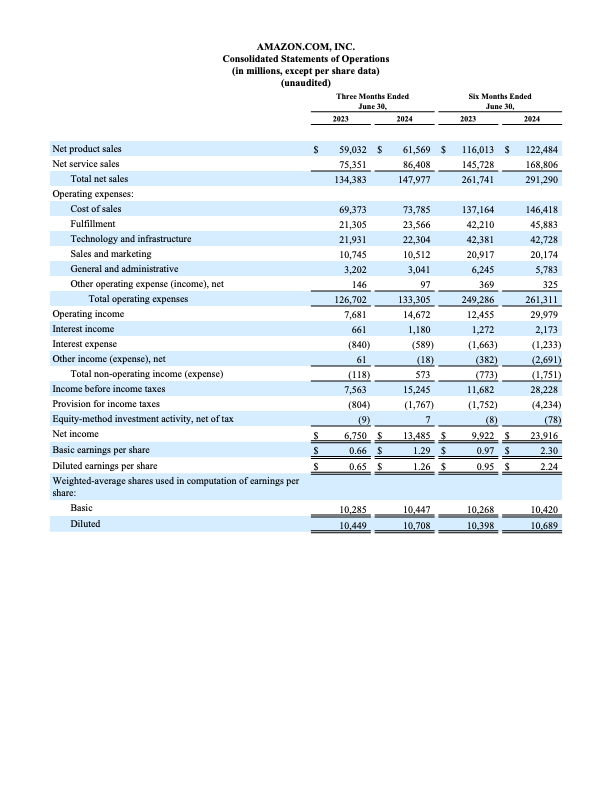

In [22]:
image="https://huggingface.co/datasets/nithiyn/bounding-box/resolve/main/AMZN-Q2-2024-Earnings-Release.jpg"
from PIL import Image
import requests
from io import BytesIO

response_img = requests.get(image)
img_report = Image.open(BytesIO(response_img.content))
print("This is the image provided to the model")
img_report.show()

In [26]:
report_analysis="""

{"url": "https://huggingface.co/datasets/nithiyn/bounding-box/resolve/main/AMZN-Q2-2024-Earnings-Release.jpg", "prompt": "Extract all the details from the provided image"}

Using Amazon's financial data for 2023 and 2024, complete the following:

Data Parsing and Code Generation: Write Python code to store Net Product Sales and Net Income for both years in a structured format (e.g., a dictionary).

Mathematical Analysis and Reasoning:

Calculate the percentage change from 2023 to 2024 for Net Product Sales and Net Income.
Determine which of these metrics had a larger increase or decrease.

Code Execution:

Execute the code to output the percentage change for each metric.
Calculate a basic profit margin (Net Income / Net Product Sales) for each year and show if it improved.
Summary Generation:

Briefly summarize your findings on any noticeable trends between 2023 and 2024.

"""

In [27]:
react_agent_executor.invoke({"input": report_analysis})



> Entering new AgentExecutor chain...
To address this question, I need to extract the details from the image first. This will help in identifying the Net Product Sales and Net Income for both years (2023 and 2024). Next, I'll write Python code to store these values and perform the necessary mathematical analysis and reasoning. Finally, I'll summarize the findings.

Action: Single image vision task

Action Input: {"url": "https://huggingface.co/datasets/nithiyn/bounding-box/resolve/main/AMZN-Q2-2024-Earnings-Release.jpg", "prompt": "Extract all the details from the provided image"}{"url": "https://huggingface.co/datasets/nithiyn/bounding-box/resolve/main/AMZN-Q2-2024-Earnings-Release.jpg", "prompt": "Extract all the details from the provided image"}
Routing prompt to: Pixtral
Response from Pixtral is # AMAZON.COM, INC.
## Consolidated Statements of Operations
### (in millions, except per share data)
### (unadjusted)

#### Three Months Ended
#### June 30,

|                       | 202

{'input': '\n\n{"url": "https://huggingface.co/datasets/nithiyn/bounding-box/resolve/main/AMZN-Q2-2024-Earnings-Release.jpg", "prompt": "Extract all the details from the provided image"}\n\nUsing Amazon\'s financial data for 2023 and 2024, complete the following:\n\nData Parsing and Code Generation: Write Python code to store Net Product Sales and Net Income for both years in a structured format (e.g., a dictionary).\n\nMathematical Analysis and Reasoning:\n\nCalculate the percentage change from 2023 to 2024 for Net Product Sales and Net Income.\nDetermine which of these metrics had a larger increase or decrease.\n\nCode Execution:\n\nExecute the code to output the percentage change for each metric.\nCalculate a basic profit margin (Net Income / Net Product Sales) for each year and show if it improved.\nSummary Generation:\n\nBriefly summarize your findings on any noticeable trends between 2023 and 2024.\n\n',
 'output': "Based on the financial analysis of Amazon's data for 2023 and 20

In the above result, we see how Mistral Large 2 routes to Pixtral, Large 2 for code gen, Jdoodle for code compilation and execution, and then mixtral for summarization

---

### 2. Math and Reasoning task and code generation + execution

**Question:**

You have a starting bank balance of $1000, and it grows each year with a fixed annual interest rate of 5%. 

1. **Math Derivation**:
   - Derive the formula to calculate the balance after a given number of years with compound interest. Use the formula:
     \[
     A = P(1 + r)^t
     \]
     where:
     - \( A \) is the balance after \( t \) years,
     - \( P \) is the starting balance ($1000),
     - \( r \) is the interest rate (5% per year),
     - \( t \) is the number of years.

2. **Code Generation**:
   - Write a Python function that uses this formula to calculate the balance after 1, 5, and 10 years.
   - Make sure to execute the code and show the balance values for each of these years.

In [33]:
test_case="""

**Question:**

You have a starting bank balance of $1000, and it grows each year with a fixed annual interest rate of 5%. 

1. **Math Derivation**:
   - Derive the formula to calculate the balance after a given number of years with compound interest. Use the formula:
     \[
     A = P(1 + r)^t
     \]
     where:
     - \( A \) is the balance after \( t \) years,
     - \( P \) is the starting balance ($1000),
     - \( r \) is the interest rate (5% per year),
     - \( t \) is the number of years.

2. **Code Generation**:
   - Write a Python function that uses this formula to calculate the balance after 1, 5, and 10 years.
   - Make sure to execute the code and show the balance values for each of these years.

"""

In [34]:
react_agent_executor.invoke({"input": test_case})



> Entering new AgentExecutor chain...
This question involves both math derivation and code generation.

First, I need to derive the formula to calculate the balance after a given number of years with compound interest. Then, I need to write a Python function that uses this formula to calculate the balance after 1, 5, and 10 years. Finally, I need to execute the code to show the balance values for each of these years.

Action: Do Math and Reasoning task
Action Input: You have a starting bank balance of $1000, and it grows each year with a fixed annual interest rate of 5%. Derive the formula to calculate the balance after a given number of years with compound interest. Use the formula:
\[
A = P(1 + r)^t
\]
where:
- \( A \) is the balance after \( t \) years,
- \( P \) is the starting balance ($1000),
- \( r \) is the interest rate (5% per year),
- \( t \) is the number of years.Routing prompt to: Mathstral
Response from Mathstral is You have a starting bank balance of $1000, and it gro

{'input': '\n\n**Question:**\n\nYou have a starting bank balance of $1000, and it grows each year with a fixed annual interest rate of 5%. \n\n1. **Math Derivation**:\n   - Derive the formula to calculate the balance after a given number of years with compound interest. Use the formula:\n     \\[\n     A = P(1 + r)^t\n     \\]\n     where:\n     - \\( A \\) is the balance after \\( t \\) years,\n     - \\( P \\) is the starting balance ($1000),\n     - \\( r \\) is the interest rate (5% per year),\n     - \\( t \\) is the number of years.\n\n2. **Code Generation**:\n   - Write a Python function that uses this formula to calculate the balance after 1, 5, and 10 years.\n   - Make sure to execute the code and show the balance values for each of these years.\n\n',
 'output': 'Balance after 1 year: $1050.00\nBalance after 5 years: $1276.28\nBalance after 10 years: $1628.89'}

---
## Simple Gradio application

In [ ]:
import gradio as gr
from io import StringIO
import sys
import re

def generate_response(question):
    """
    Generate a response based on the provided question using ChatBedrockConverse.

    Args:
    - question (str): The question input by the user.

    Returns:
    - str: The generated response based on the question.
    """
    tools = [text_gen_tool, code_gen_tool, math_reasoning_tool]

    llm = ChatBedrockConverse(model=model_id, temperature=0.9, max_tokens= 2048, client=bedrock)
    # model = OpenAI(openai_api_key="<OPENAI_API>")

    react_agent = create_react_agent(llm, tools=tools, prompt=prompt_react)
    react_agent_executor = AgentExecutor(
        agent=react_agent, tools=tools, verbose=True, handle_parsing_errors=True
    )
    
    # Redirect stdout to capture text
    with StringIO() as text_output:
        sys.stdout = text_output
        completion = react_agent_executor.invoke({"input": question})
        sys.stdout = sys.__stdout__  # Reset stdout
        
        # Get the captured text
        text_output_str = text_output.getvalue()
    
    # Remove ANSI escape codes
    text_output_str = re.sub(r'\x1b\[[0-9;]*m', '', text_output_str)

    return text_output_str

# Set up the Gradio interface
iface = gr.Interface(
    fn=generate_response,
    inputs=[gr.Textbox(label="Question")],  # Pass input as a list
    outputs=[gr.Textbox(label="Generated Response")],  # Pass output as a list
    title="Mistral LLM Router",
    description="Enter a question and get a generated response",
)

iface.launch()

---


## Distributors
- Amazon Web Services
- Mistral AI

